In [1]:
import os
import inspect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.chdir(parentdir)

from helpers import get_model, read_images

In [2]:
# Get img2pose model
model, transform = get_model()
img = plt.imread('/RG/rg-tal/orlev/datasets/original_ds/lfw/Raoul_Ruiz/Raoul_Ruiz_0004.jpg', 1)
results = model.predict([transform(img)])[0]

Model will use 1 GPUs!


/home/orlev/work/conda/envs/img2pose/lib/python3.9/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370192109/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [3]:
YAW_IMPORTANCE = 0.8
PITCH_IMPORTANCE = 0.2
SLOPE_TRAPEZOID = - 0.76
INTERCEPT_TRAPEZOID = 1.27
MIN_TRAPEZOID_INPUT = 0.35
MIN_POSE_SCORES = 0.8

def img_output_bbox(img, bbox, inc_bbox, bbox_ind):
    img_x_dim = img.shape[1]
    img_y_dim = img.shape[0]

    if not bbox_ind:
        return [0, 0, img_x_dim, img_y_dim]

    wbbox = bbox[2] - bbox[0]
    lbbox = bbox[3] - bbox[1]
    half_w = wbbox / 2
    half_l = lbbox / 2
    half_w_inc = half_w * (1 + inc_bbox)
    half_l_inc = half_l * (1 + inc_bbox)
    cx = half_w + bbox[0]
    cy = half_l + bbox[1]
    n0 = max(np.round(cx - half_w_inc).astype(int), 0)
    n1 = max(np.round(cy - half_l_inc).astype(int), 0)
    n2 = min(np.round(cx + half_w_inc).astype(int), img_x_dim - 1)
    n3 = min(np.round(cy + half_l_inc).astype(int), img_y_dim - 1)

    return [n0, n1, n2, n3]

def trapezoid(x):
    if MIN_TRAPEZOID_INPUT < abs(x):
        return SLOPE_TRAPEZOID * abs(x) + INTERCEPT_TRAPEZOID

    return 1


def pose_scores(poses):
    pitches, yaws = poses[:, 0], poses[:, 1]
    vtrapezoid = np.vectorize(trapezoid, otypes=[float])
    composition = YAW_IMPORTANCE * vtrapezoid(yaws) + PITCH_IMPORTANCE * vtrapezoid(pitches)
    scores = np.where(MIN_POSE_SCORES <= composition, composition, MIN_POSE_SCORES)

    return scores

poses = results["dofs"].cpu().numpy()[:].astype('float')
bboxes = results["boxes"].cpu().numpy()[:].astype('float')
i_scores = results["scores"].cpu().numpy()[:].astype('float')
bounding_box_size = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
center_x = (bboxes[:, 0] + bboxes[:, 2]) / 2
center_y = (bboxes[:, 1] + bboxes[:, 3]) / 2
dist_x = np.min(np.vstack((center_x, abs(center_x - img.shape[1]))), axis=0)
dist_y = np.min(np.vstack((center_y, abs(center_y - img.shape[0]))), axis=0)
offsets = np.vstack([dist_x, dist_y])
offset_dist_squared = np.sum(np.power(offsets, 2.0), 0)
p_scores = pose_scores(poses)
bbox_idx = i_scores * p_scores * (bounding_box_size + offset_dist_squared)

<ipython-input-17-13e0f2bcbefa>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.text(x1, y1, np.int(bbox_idx[result_num]),fontsize=18, color= first_color if result_num == 0 else 'w')


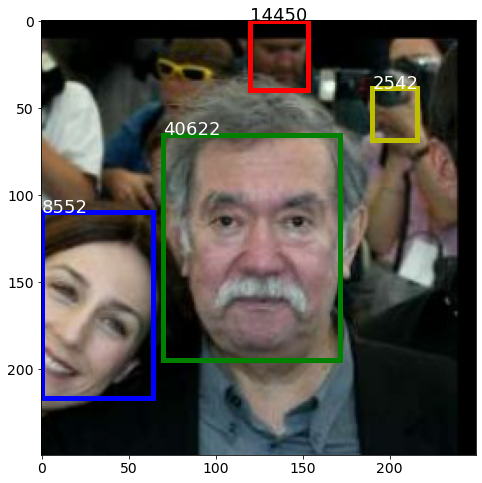

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img)
colors = ['r', 'g', 'b', 'y']
for result_num in range(len(results['labels'])):
    x1, y1, x2, y2 = results['boxes'][result_num, :].cpu()
    if 0.5 < results['scores'][result_num]:
        # Create a Rectangle patch
        first_color = 'k'
        plt.text(x1, y1, np.int(bbox_idx[result_num]),fontsize=18, color= first_color if result_num == 0 else 'w')
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=5, facecolor='none', edgecolor=colors[result_num])

        # Add the patch to the Axes
        ax.add_patch(rect)
ax.tick_params(labelsize=14)

plt.show()

# Increase bbox

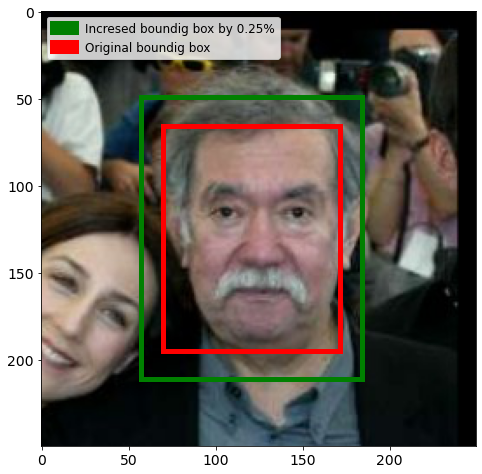

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img)
colors = ['r', 'g', 'b', 'y']
x1, y1, x2, y2 = results['boxes'][1, :].cpu()

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=5, facecolor='none', edgecolor=colors[0])
ax.add_patch(rect)

inc_bbox = 0.25
bbox = results['boxes'][1, :].cpu().numpy()
x1, y1, x2, y2 = img_output_bbox(img, bbox, inc_bbox, bbox_ind = True)

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=5, facecolor='none', edgecolor=colors[1])

# Add the patch to the Axes
ax.add_patch(rect)
ax.legend(['Incresed boundig box by 0.25%', 'Original boundig box'],
           loc="upper left", ncol=1,prop={'size': 12})
ax.tick_params(labelsize=14)

leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('red')

plt.show()

# Trapozoid function

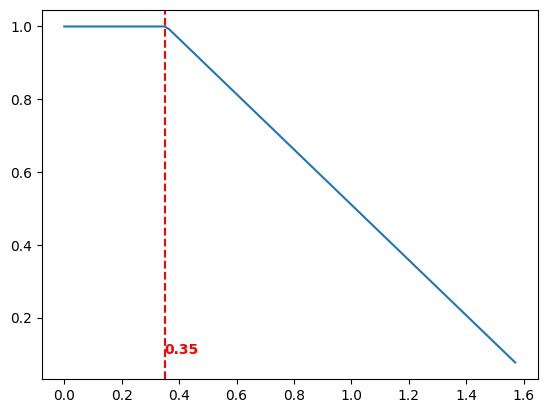

In [122]:
x = np.linspace(0, 1.57, num=100)
trapezoid = np.vectorize(trapezoid, otypes=[float])
y = trapezoid(x)
plt.plot(x,y, color='C0')
plt.axvline(MIN_TRAPEZOID_INPUT,linestyle="--", color='red')
plt.text(MIN_TRAPEZOID_INPUT, 0.1,MIN_TRAPEZOID_INPUT , fontsize=10.0, fontweight='bold', color='red' )
plt.show()